# Nuclear Stance Classification Results

Visualizes output from `classify_initiative_and_feedback.py`.

In [2]:
import json
import os
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd

pd.set_option("display.max_colwidth", 120)
plt.rcParams["figure.dpi"] = 120

Matplotlib is building the font cache; this may take a moment.


In [9]:
# --- CONFIGURE ---
INPUT_DIR = "classification_results_v3/"  # output dir from classify_initiative_and_feedback.py
# -----------------

## Load data

In [10]:
initiatives = []
feedback_rows = []

for fname in sorted(os.listdir(INPUT_DIR)):
    if not fname.endswith(".json") or fname.startswith("_"):
        continue
    with open(os.path.join(INPUT_DIR, fname), encoding="utf-8") as f:
        d = json.load(f)

    # Normalize stance fields — could be a single value or list (multi-run)
    def get_stance(val):
        if isinstance(val, list):
            return val  # multi-run
        return [val] if val is not None else []

    row = {
        "id": d["id"],
        "short_title": d.get("short_title", ""),
        "type_of_act": d.get("type_of_act", ""),
        "department": d.get("department", ""),
        "topics": ", ".join(d.get("topics", [])),
        "policy_areas": ", ".join(d.get("policy_areas", [])),
        "published_date": d.get("published_date", ""),
        "n_feedback": len(d.get("middle_feedback", [])),
        "before_stance": get_stance(d.get("before_feedback_nuclear_stance")),
        "after_stance": get_stance(d.get("after_feedback_nuclear_stance")),
        "before_complex": get_stance(d.get("before_feedback_nuclear_stance_complex")),
        "after_complex": get_stance(d.get("after_feedback_nuclear_stance_complex")),
    }
    initiatives.append(row)

    for fb in d.get("middle_feedback", []):
        fb_stance = get_stance(fb.get("nuclear_stance"))
        if fb_stance:
            feedback_rows.append({
                "initiative_id": d["id"],
                "short_title": d.get("short_title", ""),
                "feedback_id": fb.get("id"),
                "user_type": fb.get("user_type", ""),
                "country": fb.get("country", ""),
                "organization": fb.get("organization", ""),
                "stance": fb_stance,
            })

df_init = pd.DataFrame(initiatives)
df_fb = pd.DataFrame(feedback_rows)

# Detect number of runs
n_runs = max(len(df_init["before_stance"].iloc[0]), 1) if len(df_init) else 1

print(f"Loaded {len(df_init)} initiatives, {len(df_fb)} feedback items")
print(f"Runs per prompt: {n_runs}")

Loaded 118 initiatives, 77968 feedback items
Runs per prompt: 1


## Helper: majority vote (for multi-run)

In [11]:
LABEL_ORDER = ["SUPPORT", "NEUTRAL", "OPPOSE", "DOES NOT MENTION"]
LABEL_COLORS = {
    "SUPPORT": "#2ecc71",
    "NEUTRAL": "#f39c12",
    "OPPOSE": "#e74c3c",
    "DOES NOT MENTION": "#95a5a6",
}


def majority(labels):
    """Return majority label from a list; None if empty."""
    if not labels:
        return None
    c = Counter(labels)
    return c.most_common(1)[0][0]


def agreement_rate(labels):
    """Fraction of runs that agree with the majority."""
    if not labels or len(labels) <= 1:
        return 1.0
    c = Counter(labels)
    return c.most_common(1)[0][1] / len(labels)

## 1. Initiative-level: Simple stance distribution

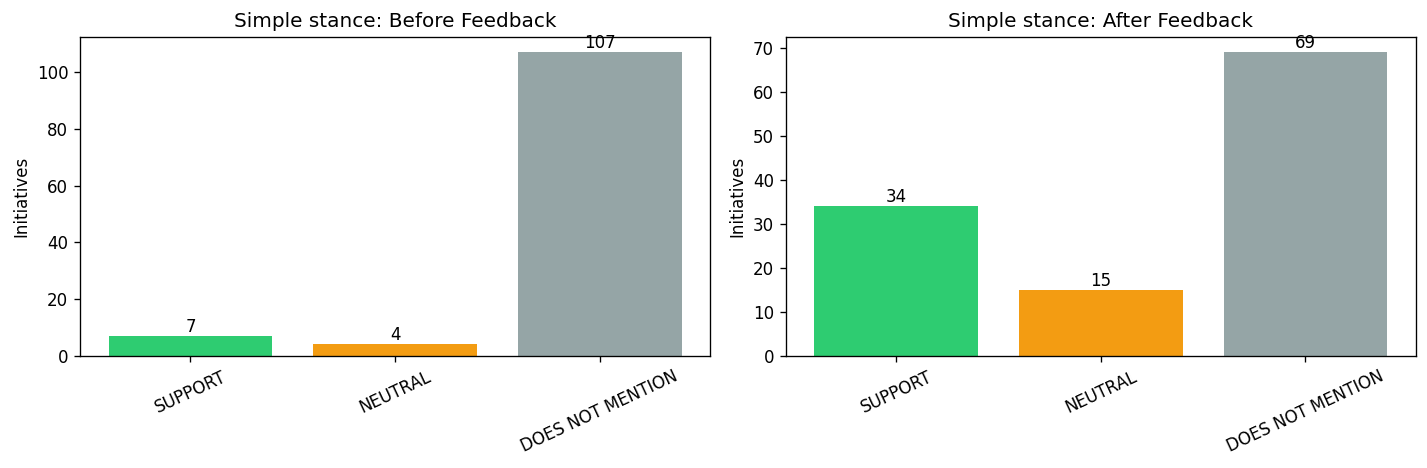

In [12]:
df_init["before_majority"] = df_init["before_stance"].apply(majority)
df_init["after_majority"] = df_init["after_stance"].apply(majority)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, col, title in [
    (axes[0], "before_majority", "Before Feedback"),
    (axes[1], "after_majority", "After Feedback"),
]:
    counts = df_init[col].value_counts()
    counts = counts.reindex(LABEL_ORDER).dropna().astype(int)
    colors = [LABEL_COLORS[l] for l in counts.index]
    bars = ax.bar(counts.index, counts.values, color=colors)
    ax.bar_label(bars)
    ax.set_title(f"Simple stance: {title}")
    ax.set_ylabel("Initiatives")
    ax.tick_params(axis="x", rotation=25)

fig.tight_layout()
plt.show()

## 2. Before vs After comparison (simple)

118 initiatives have both before and after classifications



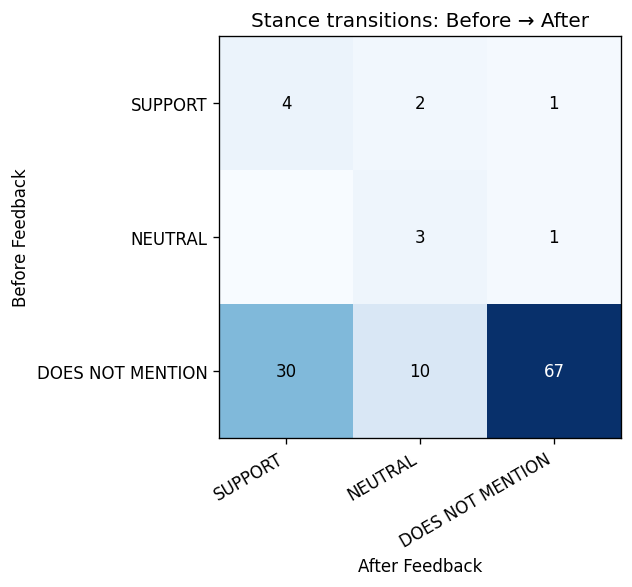


44 initiatives changed stance:


,id,short_title,before_majority,after_majority
0,12152,Approval of automated vehicles and of systems intended for such vehicles,SUPPORT,NEUTRAL
1,12154,Europe’s Beating Cancer Plan,DOES NOT MENTION,SUPPORT
2,12227,Revision of the Energy Tax Directive,DOES NOT MENTION,NEUTRAL
3,12265,2030 Climate Target Plan,DOES NOT MENTION,SUPPORT
4,12302,Climate change mitigation and adaptation taxonomy,DOES NOT MENTION,SUPPORT
5,12303,ReFuelEU Aviation - Sustainable Aviation Fuels,DOES NOT MENTION,NEUTRAL
6,12306,EU rules on industrial emissions - revision,DOES NOT MENTION,SUPPORT
7,12381,EU Strategy on Adaptation to Climate Change,DOES NOT MENTION,SUPPORT
8,12382,Revision of the guidelines for trans-European Energy infrastructure,DOES NOT MENTION,SUPPORT
9,12383,Strategy for smart sector integration,DOES NOT MENTION,SUPPORT


In [13]:
has_both = df_init.dropna(subset=["before_majority", "after_majority"])
print(f"{len(has_both)} initiatives have both before and after classifications\n")

# Transition matrix
transitions = pd.crosstab(
    has_both["before_majority"], has_both["after_majority"],
    rownames=["Before"], colnames=["After"],
)
transitions = transitions.reindex(index=LABEL_ORDER, columns=LABEL_ORDER, fill_value=0)
transitions = transitions.loc[
    transitions.sum(axis=1) > 0, transitions.sum(axis=0) > 0
]

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(transitions.values, cmap="Blues")
ax.set_xticks(range(len(transitions.columns)))
ax.set_xticklabels(transitions.columns, rotation=30, ha="right")
ax.set_yticks(range(len(transitions.index)))
ax.set_yticklabels(transitions.index)
ax.set_xlabel("After Feedback")
ax.set_ylabel("Before Feedback")
ax.set_title("Stance transitions: Before → After")
for i in range(len(transitions.index)):
    for j in range(len(transitions.columns)):
        v = transitions.values[i, j]
        if v > 0:
            ax.text(j, i, str(v), ha="center", va="center",
                    color="white" if v > transitions.values.max() / 2 else "black")
fig.tight_layout()
plt.show()

# List initiatives that changed stance
changed = has_both[has_both["before_majority"] != has_both["after_majority"]]
if len(changed):
    print(f"\n{len(changed)} initiatives changed stance:")
    display(changed[["id", "short_title", "before_majority", "after_majority"]].reset_index(drop=True))
else:
    print("No initiatives changed stance between before and after.")

## 3. Multi-run agreement (if runs > 1)

In [14]:
if n_runs > 1:
    df_init["before_agreement"] = df_init["before_stance"].apply(agreement_rate)
    df_init["after_agreement"] = df_init["after_stance"].apply(agreement_rate)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    for ax, col, title in [
        (axes[0], "before_agreement", "Before Feedback"),
        (axes[1], "after_agreement", "After Feedback"),
    ]:
        vals = df_init[col].dropna()
        ax.hist(vals, bins=np.linspace(0, 1, n_runs + 1), edgecolor="black", alpha=0.7)
        ax.set_title(f"Agreement rate: {title}")
        ax.set_xlabel("Fraction agreeing with majority")
        ax.set_ylabel("Initiatives")
        ax.axvline(vals.mean(), color="red", ls="--", label=f"mean={vals.mean():.2f}")
        ax.legend()
    fig.tight_layout()
    plt.show()

    # Show low-agreement initiatives
    low = df_init[
        (df_init["before_agreement"] < 1.0) | (df_init["after_agreement"] < 1.0)
    ]
    if len(low):
        print(f"{len(low)} initiatives with disagreement across runs:")
        show_cols = ["id", "short_title", "before_stance", "before_agreement",
                     "after_stance", "after_agreement"]
        display(low[show_cols].sort_values("before_agreement").reset_index(drop=True))
else:
    print("Single run — skip agreement analysis.")

Single run — skip agreement analysis.


## 4. Feedback-level stance distribution

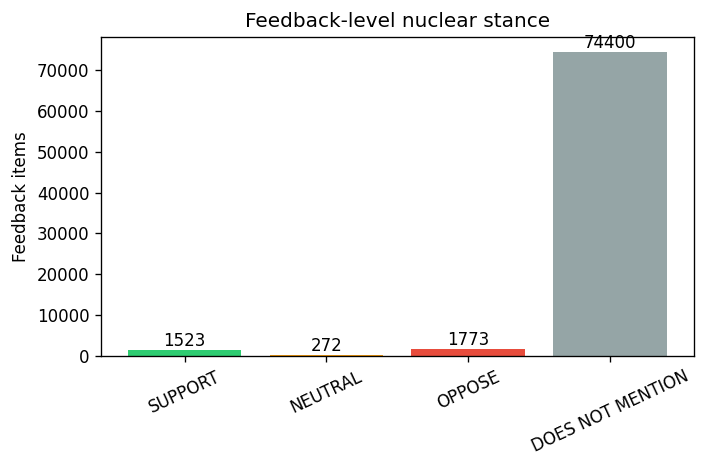

In [15]:
if len(df_fb):
    df_fb["stance_majority"] = df_fb["stance"].apply(majority)

    counts = df_fb["stance_majority"].value_counts()
    counts = counts.reindex(LABEL_ORDER).dropna().astype(int)
    colors = [LABEL_COLORS[l] for l in counts.index]

    fig, ax = plt.subplots(figsize=(6, 4))
    bars = ax.bar(counts.index, counts.values, color=colors)
    ax.bar_label(bars)
    ax.set_title("Feedback-level nuclear stance")
    ax.set_ylabel("Feedback items")
    ax.tick_params(axis="x", rotation=25)
    fig.tight_layout()
    plt.show()
else:
    print("No feedback classifications found.")

## 5. Feedback stance by user type

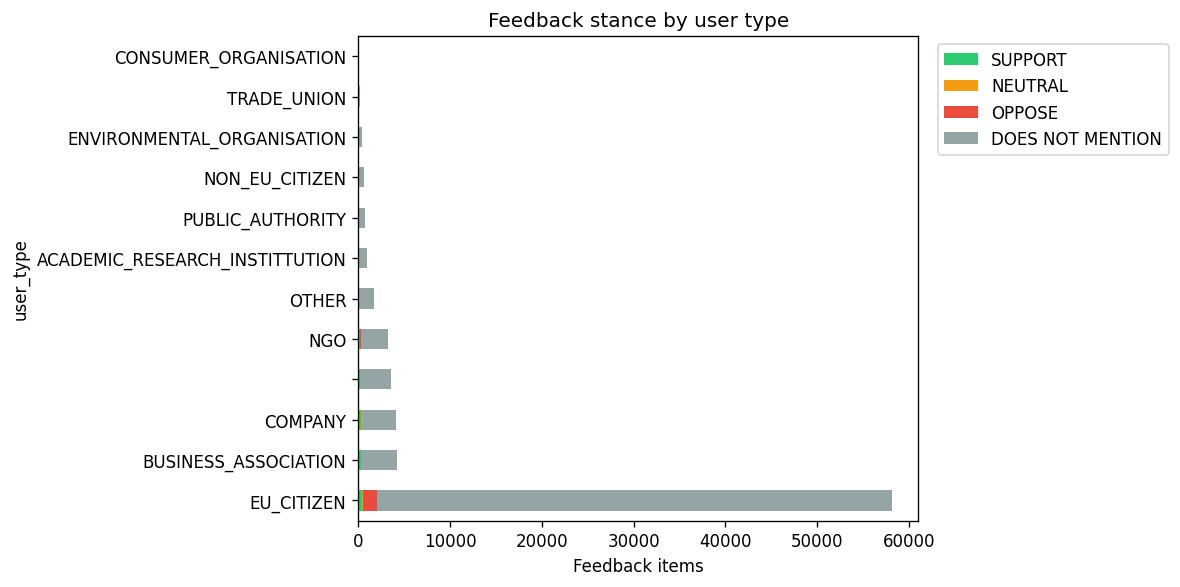

In [16]:
if len(df_fb):
    ct = pd.crosstab(df_fb["user_type"], df_fb["stance_majority"])
    ct = ct.reindex(columns=LABEL_ORDER, fill_value=0)
    ct = ct.loc[ct.sum(axis=1).sort_values(ascending=False).index]

    fig, ax = plt.subplots(figsize=(10, 5))
    ct.plot.barh(
        stacked=True, ax=ax,
        color=[LABEL_COLORS[l] for l in ct.columns],
    )
    ax.set_xlabel("Feedback items")
    ax.set_title("Feedback stance by user type")
    ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
    fig.tight_layout()
    plt.show()

## 6. Feedback stance by country (top 15)

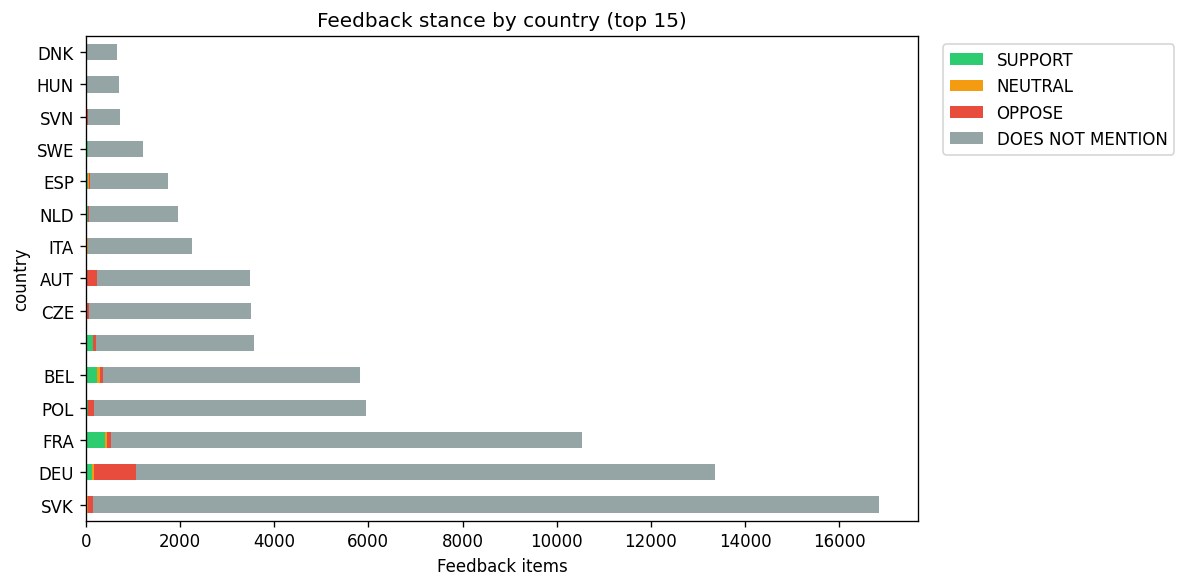

In [17]:
if len(df_fb) and "country" in df_fb.columns:
    top_countries = df_fb["country"].value_counts().head(15).index
    ct = pd.crosstab(
        df_fb[df_fb["country"].isin(top_countries)]["country"],
        df_fb[df_fb["country"].isin(top_countries)]["stance_majority"],
    )
    ct = ct.reindex(columns=LABEL_ORDER, fill_value=0)
    ct = ct.loc[ct.sum(axis=1).sort_values(ascending=False).index]

    fig, ax = plt.subplots(figsize=(10, 5))
    ct.plot.barh(
        stacked=True, ax=ax,
        color=[LABEL_COLORS[l] for l in ct.columns],
    )
    ax.set_xlabel("Feedback items")
    ax.set_title("Feedback stance by country (top 15)")
    ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
    fig.tight_layout()
    plt.show()

## 7. Per-initiative feedback breakdown

/var/folders/gx/m4r_gc751jq23rrrjzcrs5xr0000gn/T/ipykernel_84141/311493773.py:18: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


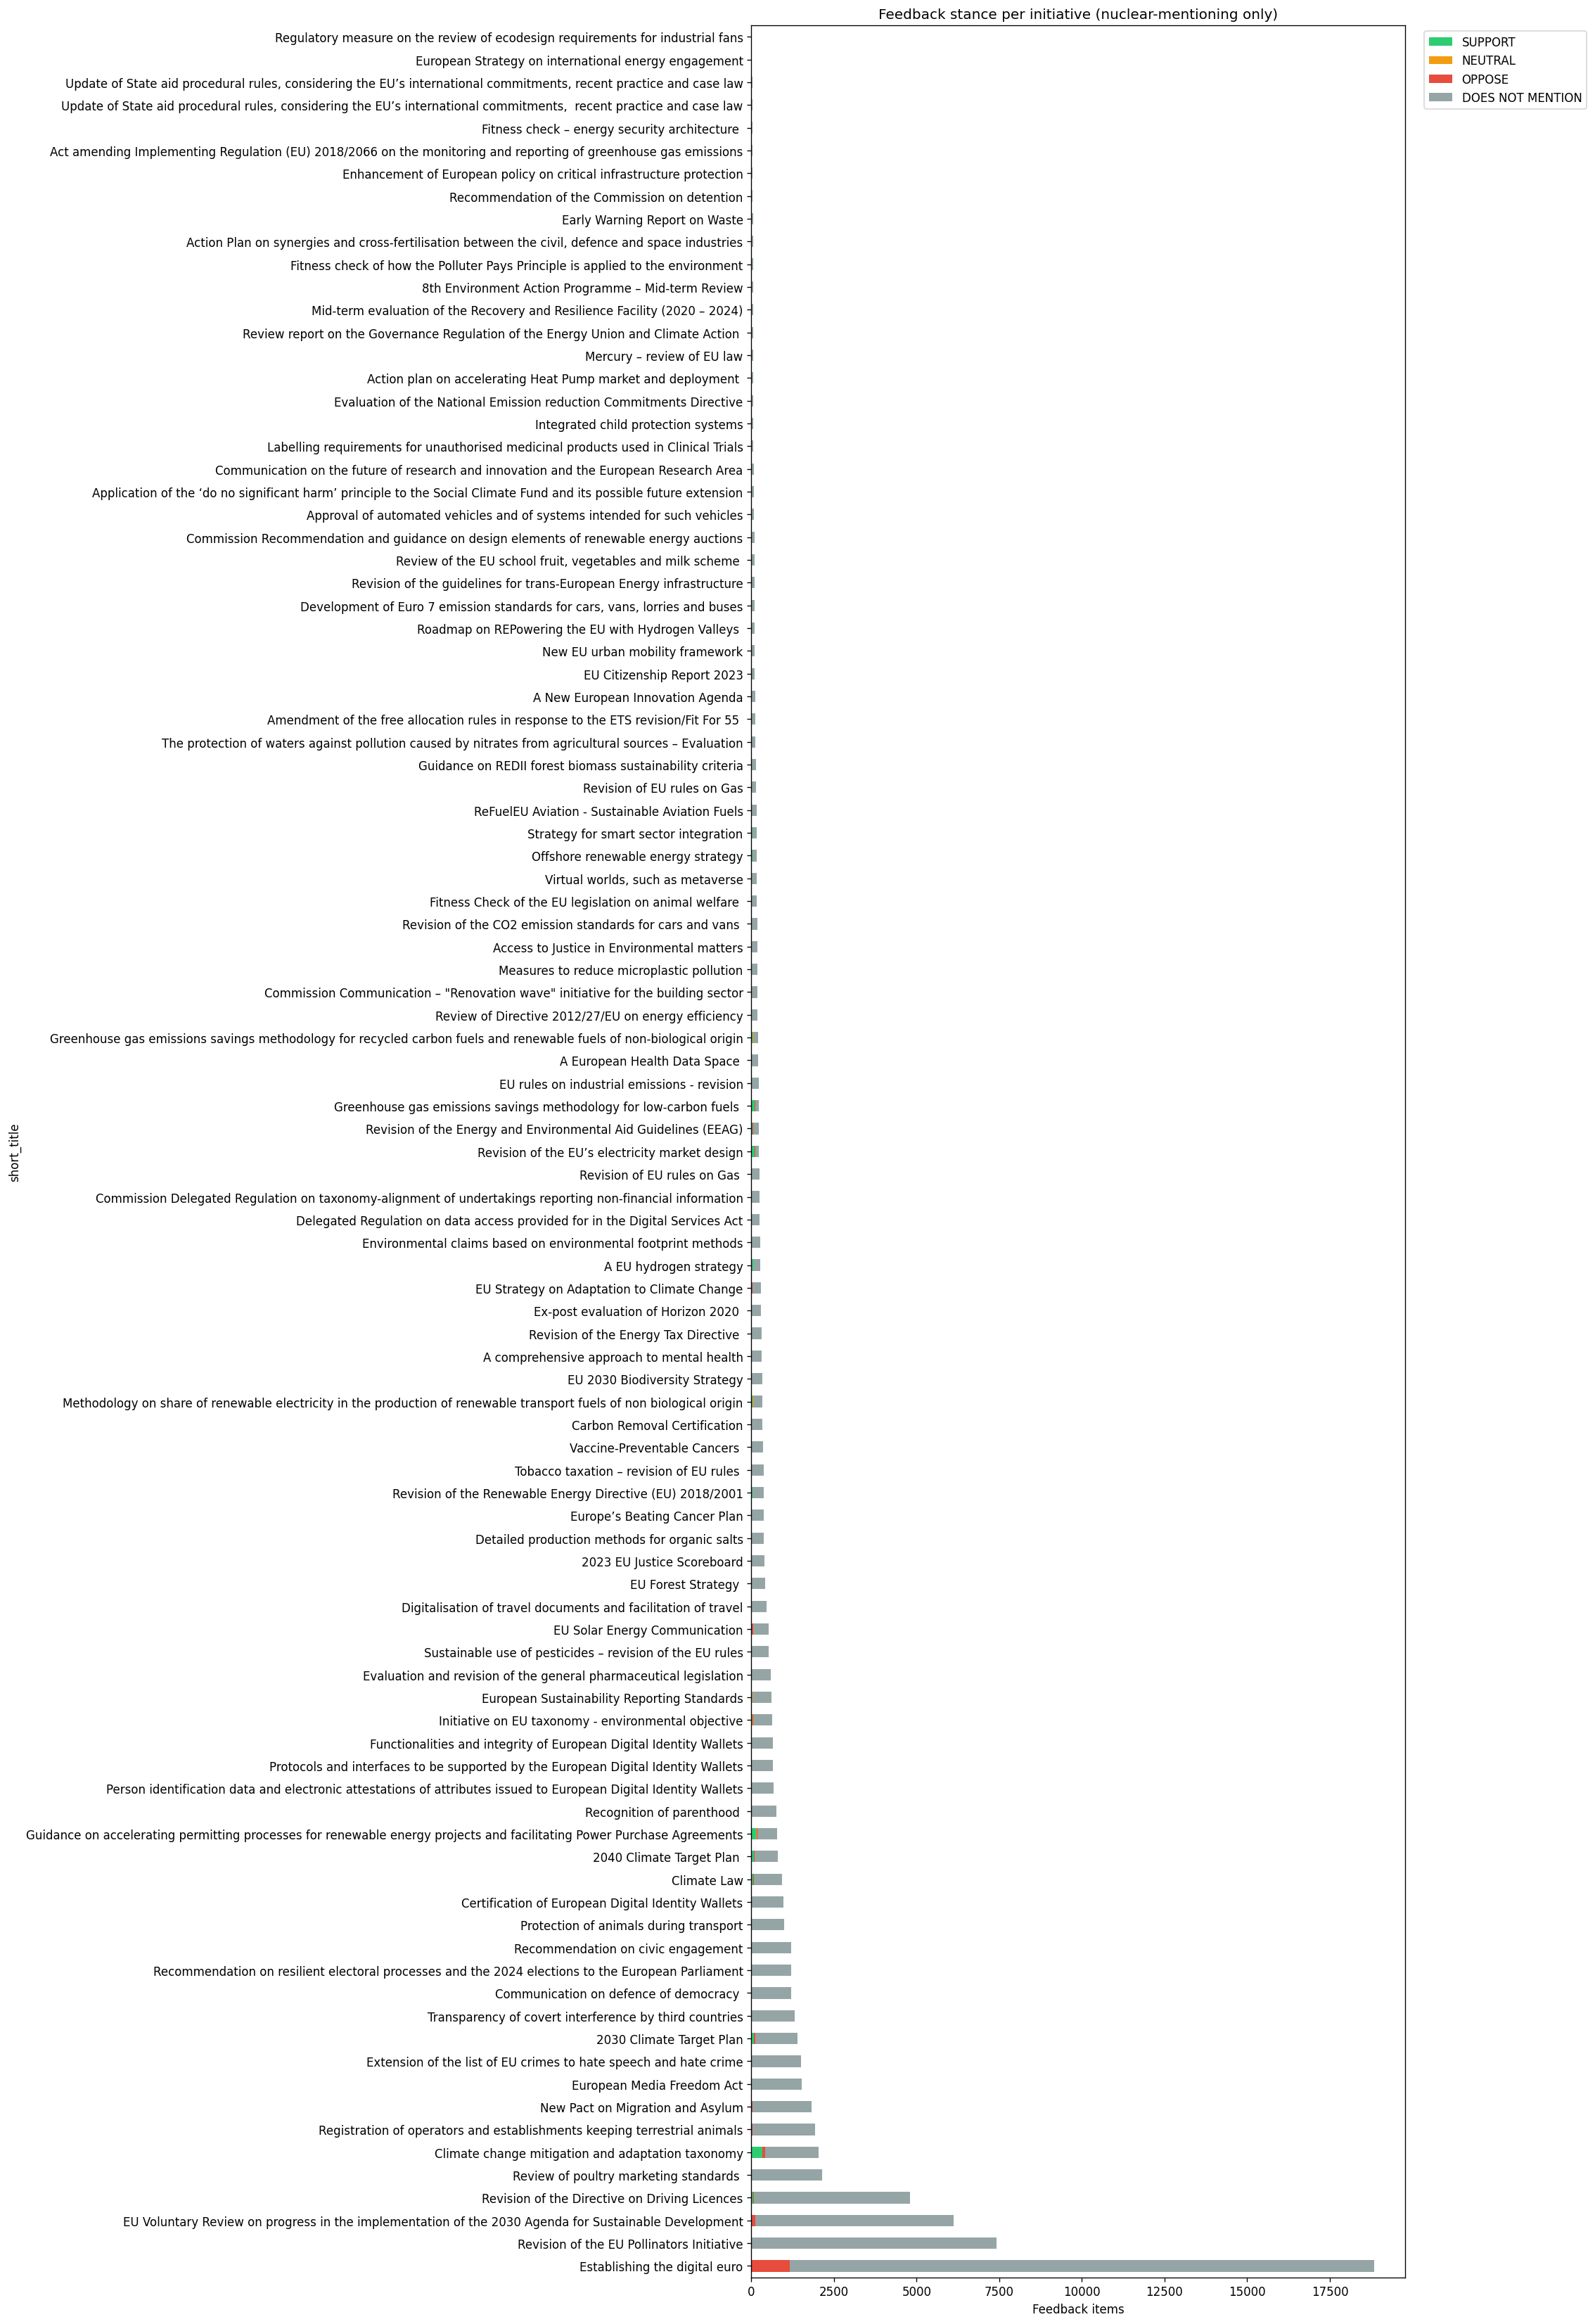

In [18]:
if len(df_fb):
    ct = pd.crosstab(df_fb["short_title"], df_fb["stance_majority"])
    ct = ct.reindex(columns=LABEL_ORDER, fill_value=0)
    # Only show initiatives with at least one non-"DOES NOT MENTION" feedback
    mentions = ct.drop(columns="DOES NOT MENTION", errors="ignore").sum(axis=1)
    ct_show = ct[mentions > 0].copy()
    ct_show = ct_show.loc[ct_show.sum(axis=1).sort_values(ascending=False).index]

    if len(ct_show):
        fig, ax = plt.subplots(figsize=(10, max(4, len(ct_show) * 0.35)))
        ct_show.plot.barh(
            stacked=True, ax=ax,
            color=[LABEL_COLORS[l] for l in ct_show.columns],
        )
        ax.set_xlabel("Feedback items")
        ax.set_title("Feedback stance per initiative (nuclear-mentioning only)")
        ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
        fig.tight_layout()
        plt.show()
    else:
        print("No initiatives have nuclear-mentioning feedback.")

## 8. Complex classification results

In [20]:
has_complex = df_init[df_init["before_complex"].apply(len) > 0].copy()

if len(has_complex):
    # For complex output, each entry is free-form text — display as a table
    rows = []
    for _, r in has_complex.iterrows():
        for phase, col in [("before", "before_complex"), ("after", "after_complex")]:
            for run_idx, text in enumerate(r[col]):
                if text:
                    rows.append({
                        "id": r["id"],
                        "short_title": r["short_title"],
                        "phase": phase,
                        "run": run_idx,
                        "complex_output": text[:300] + ("..." if len(text) > 300 else ""),
                    })
    df_complex = pd.DataFrame(rows)
    print(f"{len(df_complex)} complex classification outputs")
    display(df_complex)
else:
    print("No complex classification results found.")

No complex classification results found.


## 9. Initiatives and feedback by stance transition

For each (before, after) stance pair, shows the initiatives in that group and
their feedback stance breakdown.

In [ ]:
has_both = df_init.dropna(subset=["before_majority", "after_majority"]).copy()

MAX_TITLE_LEN = 40

if not len(has_both):
    print("No initiatives with both before and after classifications.")
else:
    # Build feedback stance counts per initiative
    fb_counts_by_init = {}
    if len(df_fb):
        for init_id, grp in df_fb.groupby("initiative_id"):
            fb_counts_by_init[init_id] = Counter(grp["stance_majority"])

    def make_chart_label(init_id, title):
        if len(title) > MAX_TITLE_LEN:
            title = title[:MAX_TITLE_LEN] + "..."
        return f"{init_id}: {title}"

    # Iterate over every observed (before, after) transition
    transition_pairs = (
        has_both.groupby(["before_majority", "after_majority"])
        .size()
        .sort_values(ascending=False)
    )

    for (before_label, after_label), count in transition_pairs.items():
        subset = has_both[
            (has_both["before_majority"] == before_label)
            & (has_both["after_majority"] == after_label)
        ].sort_values("id")

        print(f"\n{'='*70}")
        print(f"  {before_label}  -->  {after_label}   ({count} initiative{'s' if count != 1 else ''})")
        print(f"{'='*70}\n")

        # Table of initiatives in this group
        display(
            subset[["id", "short_title", "n_feedback", "policy_areas"]]
            .reset_index(drop=True)
        )

        # Feedback stance breakdown for this group
        group_ids = set(subset["id"])
        group_fb_total = Counter()
        for iid in group_ids:
            group_fb_total.update(fb_counts_by_init.get(iid, {}))

        if group_fb_total:
            labels_present = [l for l in LABEL_ORDER if group_fb_total.get(l, 0) > 0]
            vals = [group_fb_total[l] for l in labels_present]
            colors = [LABEL_COLORS[l] for l in labels_present]

            n_inits = len(subset)
            fig, axes = plt.subplots(1, 2, figsize=(14, max(3.5, n_inits * 0.35 + 1)))

            # Bar chart of absolute counts
            bars = axes[0].bar(labels_present, vals, color=colors)
            axes[0].bar_label(bars)
            axes[0].set_ylabel("Feedback items")
            axes[0].set_title("Feedback stance (counts)")
            axes[0].tick_params(axis="x", rotation=25)

            # Per-initiative stacked bar (% of each initiative's feedback)
            init_rows = []
            for _, r in subset.iterrows():
                fc = fb_counts_by_init.get(r["id"], {})
                total = sum(fc.values()) or 1
                row = {l: fc.get(l, 0) / total for l in LABEL_ORDER}
                row["label"] = make_chart_label(r["id"], r["short_title"])
                init_rows.append(row)
            df_pct = pd.DataFrame(init_rows).set_index("label")
            df_pct = df_pct[LABEL_ORDER]

            df_pct.plot.barh(
                stacked=True, ax=axes[1],
                color=[LABEL_COLORS[l] for l in LABEL_ORDER],
                legend=False,
            )
            axes[1].set_xlabel("Fraction of feedback")
            axes[1].set_title("Feedback stance per initiative (%)")
            axes[1].legend(bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=8)
            axes[1].set_xlim(0, 1)

            fig.suptitle(
                f"{before_label}  -->  {after_label}",
                fontsize=11, fontweight="bold", y=1.02,
            )
            fig.tight_layout()
            plt.show()
        else:
            print("  (no feedback for initiatives in this group)")